Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

--------------------------------------------------
 >>> Starting Leave-One-Subject-Out (LOSO) CV
--------------------------------------------------
[Fold 1] lag_w_mean = [0.0225 0.0276 0.0233 0.0402 0.0365 0.0195 0.0109 0.04   0.0479 0.0469
 0.0277 0.007  0.0454 0.047  0.0374 0.0169 0.0224 0.0316 0.0336 0.025
 0.0704 0.0243 0.0362 0.0411 0.0413 0.0476 0.0407 0.0291 0.0139 0.0199
 0.0265]
[Fold 1] mean lag (frames) = 15.29 | mode(argmax lag) = 20
Fold  1 | Test: subject1 | MAE: 1.71 | [Pred: 18.3 / GT: 20]
[Fold 2] lag_w_mean = [0.0194 0.0255 0.0243 0.0374 0.0375 0.023  0.0092 0.0382 0.0526 0.043
 0.0269 0.0059 0.0433 0.0507 0.0374 0.0157 0.0221 0.03   0.0345 0.0227
 0.0704 0.0222 0.0354 0.044  0.0415 0.0464 0.0423 0.0311 0.0131 0.0243
 0.0302]
[Fold 2] mean lag (frames) = 15.50 | mode(argmax lag) = 20
Fold  2 | Test: subject2 | MAE: 6.48 | [Pred: 16.0 / GT: 22]
[Fold 3] lag_w_mean =

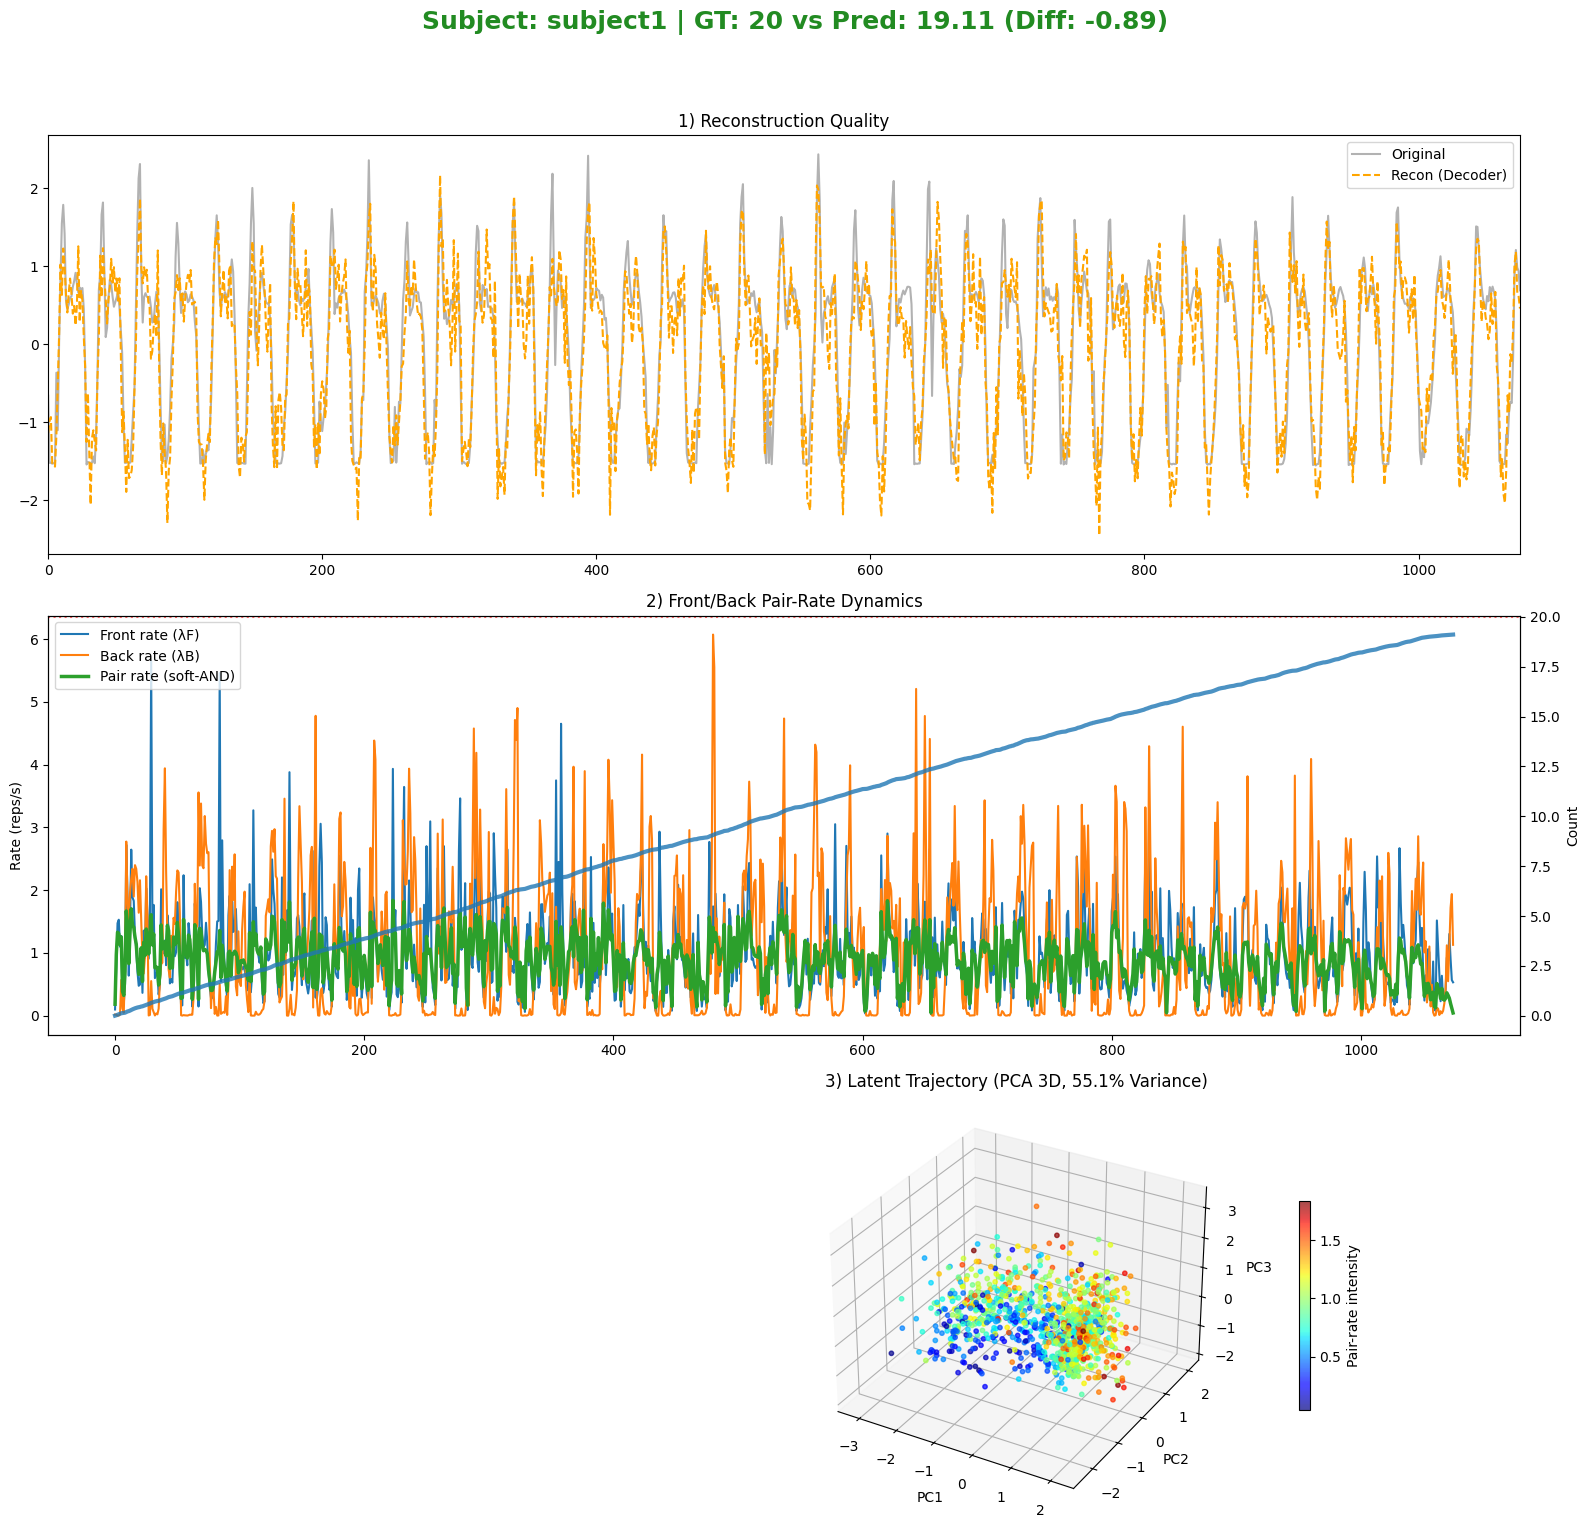

Done subject1...



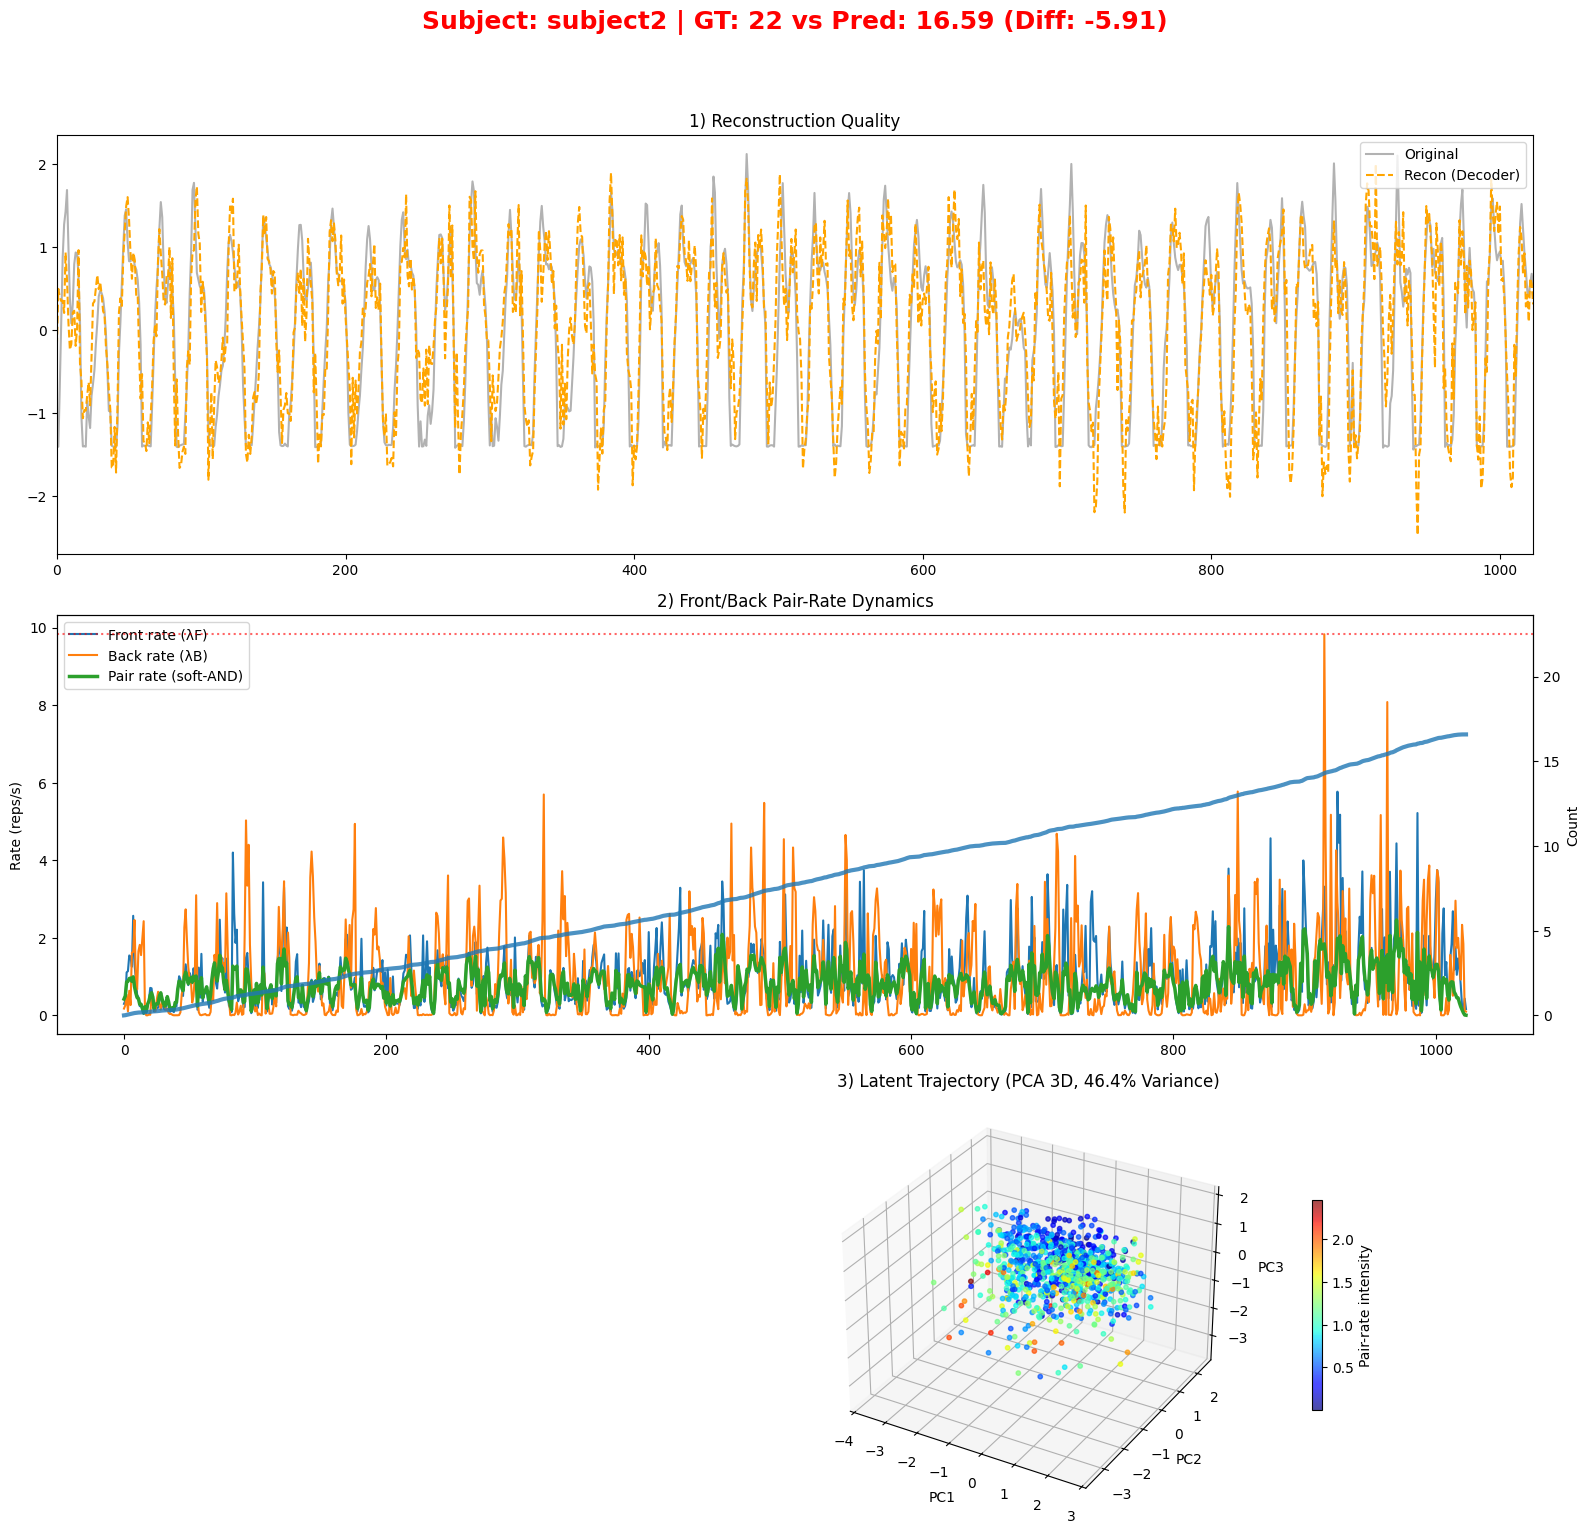

Done subject2...



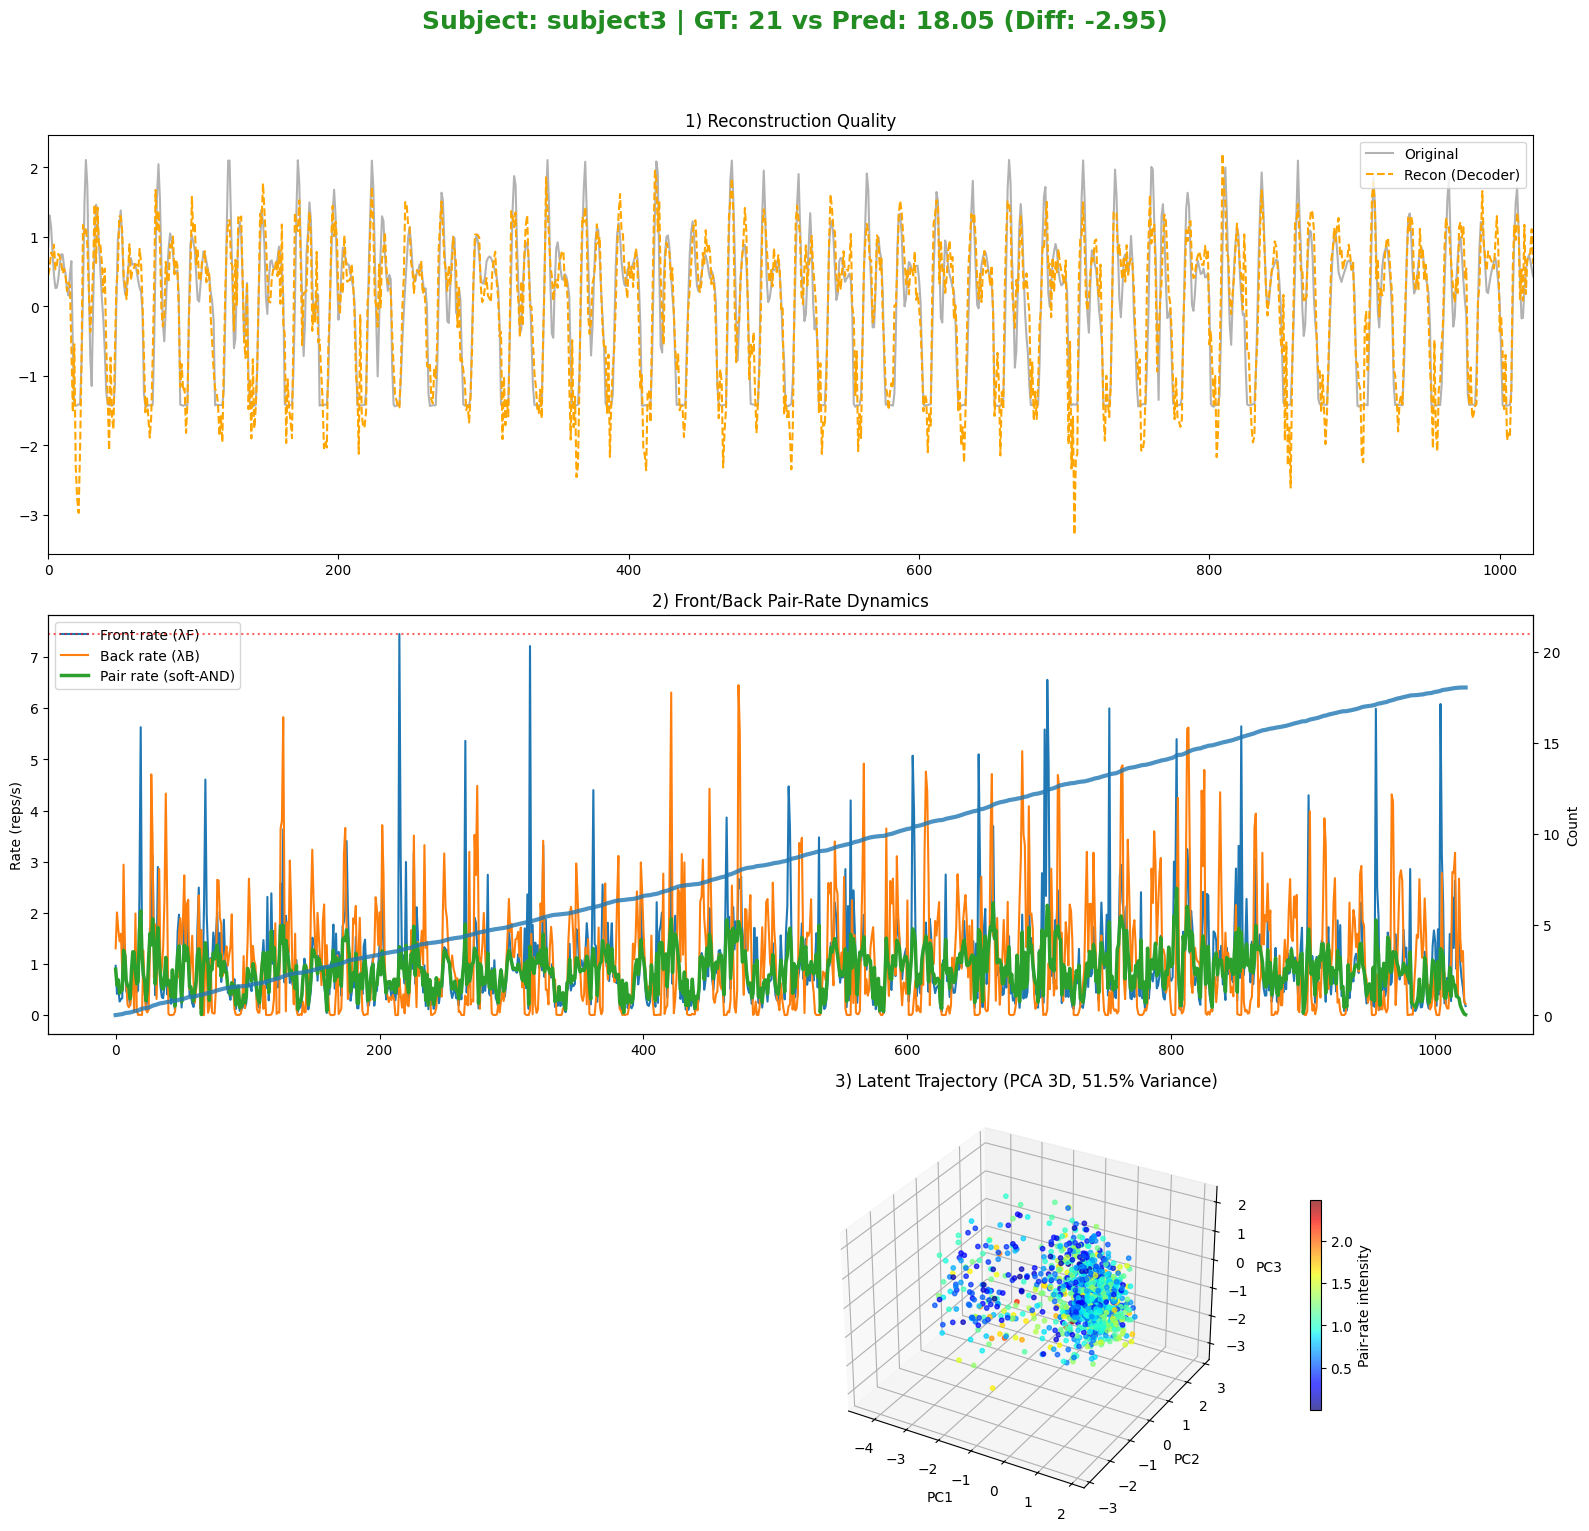

Done subject3...



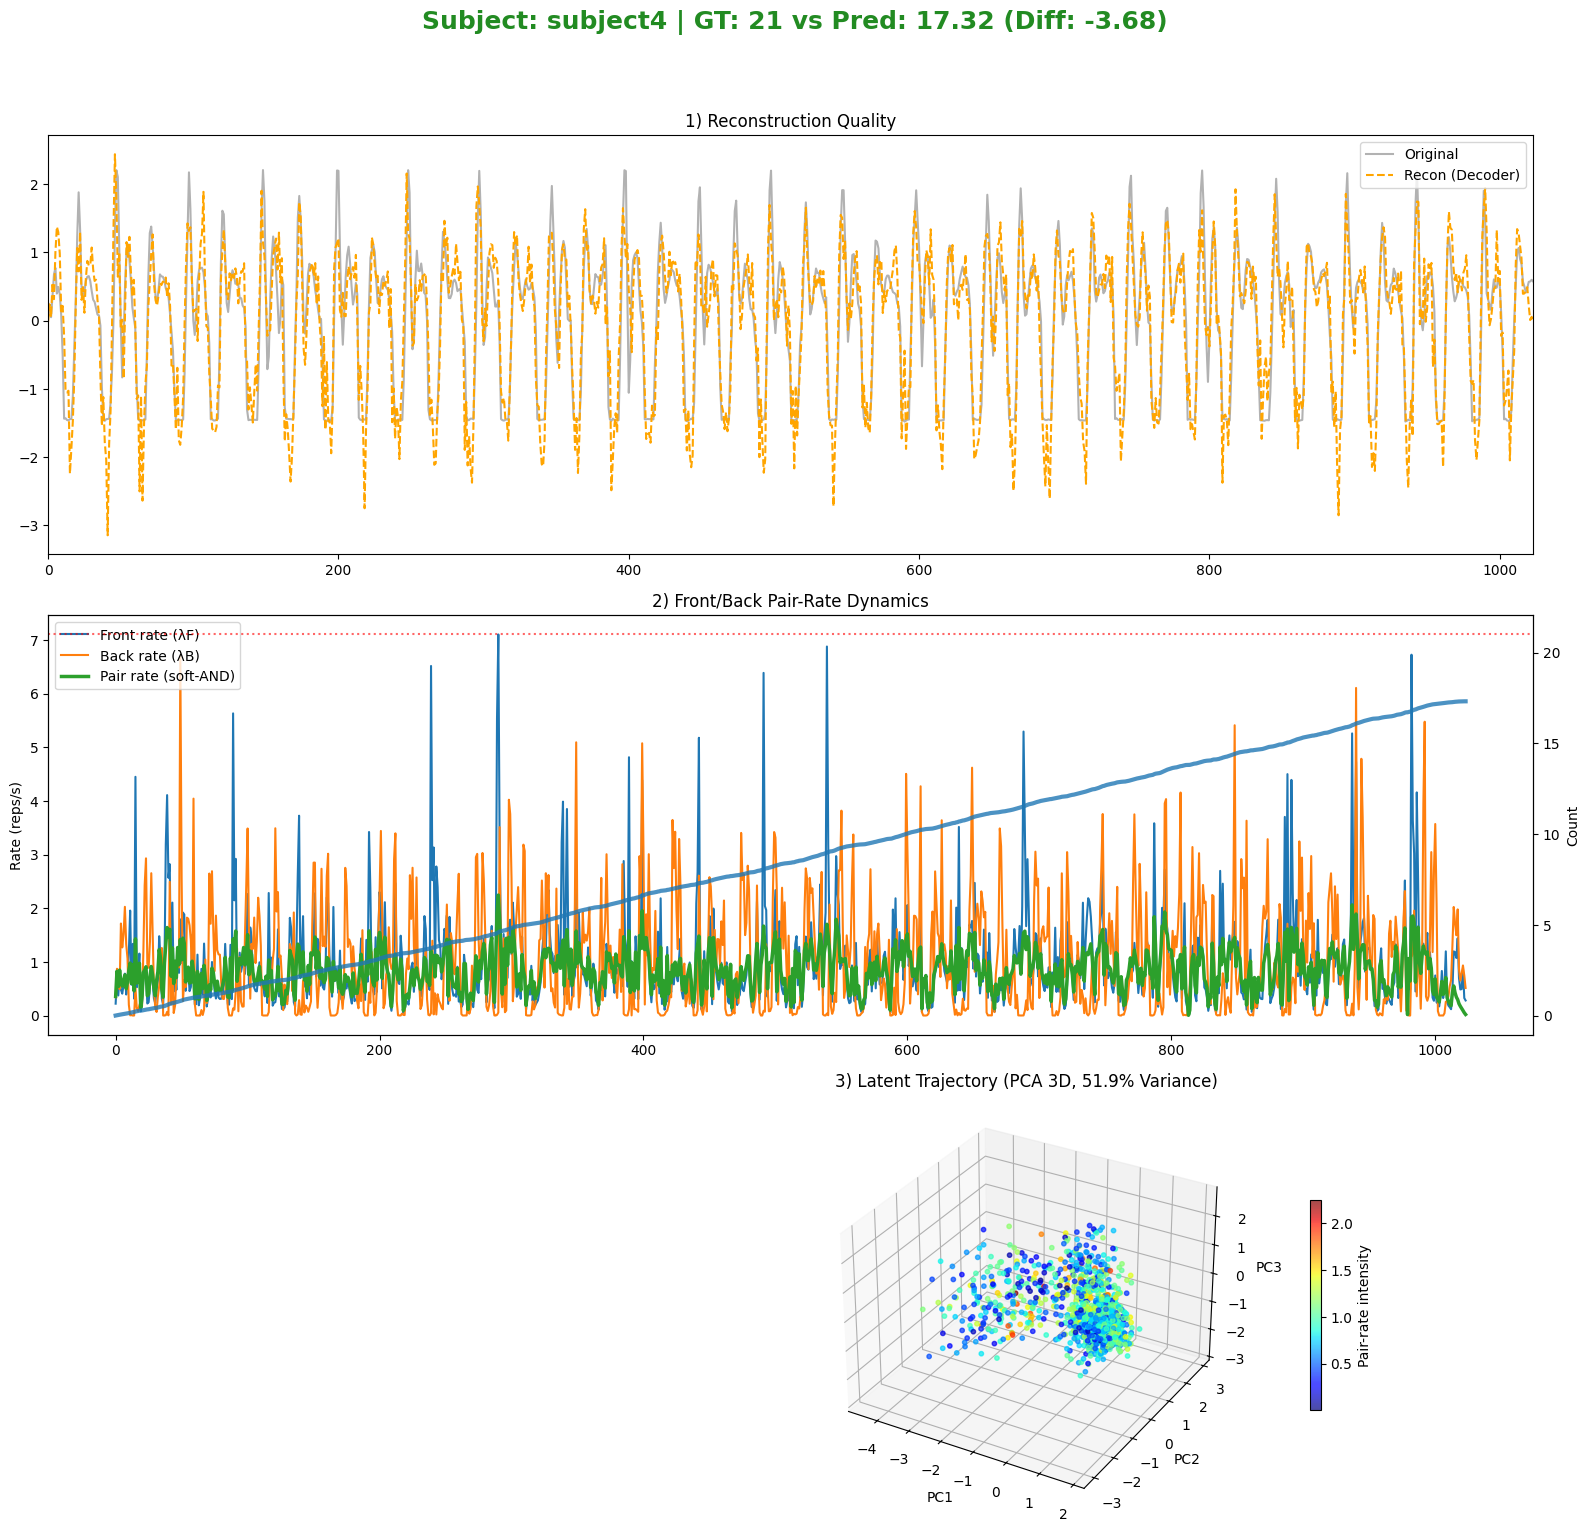

Done subject4...



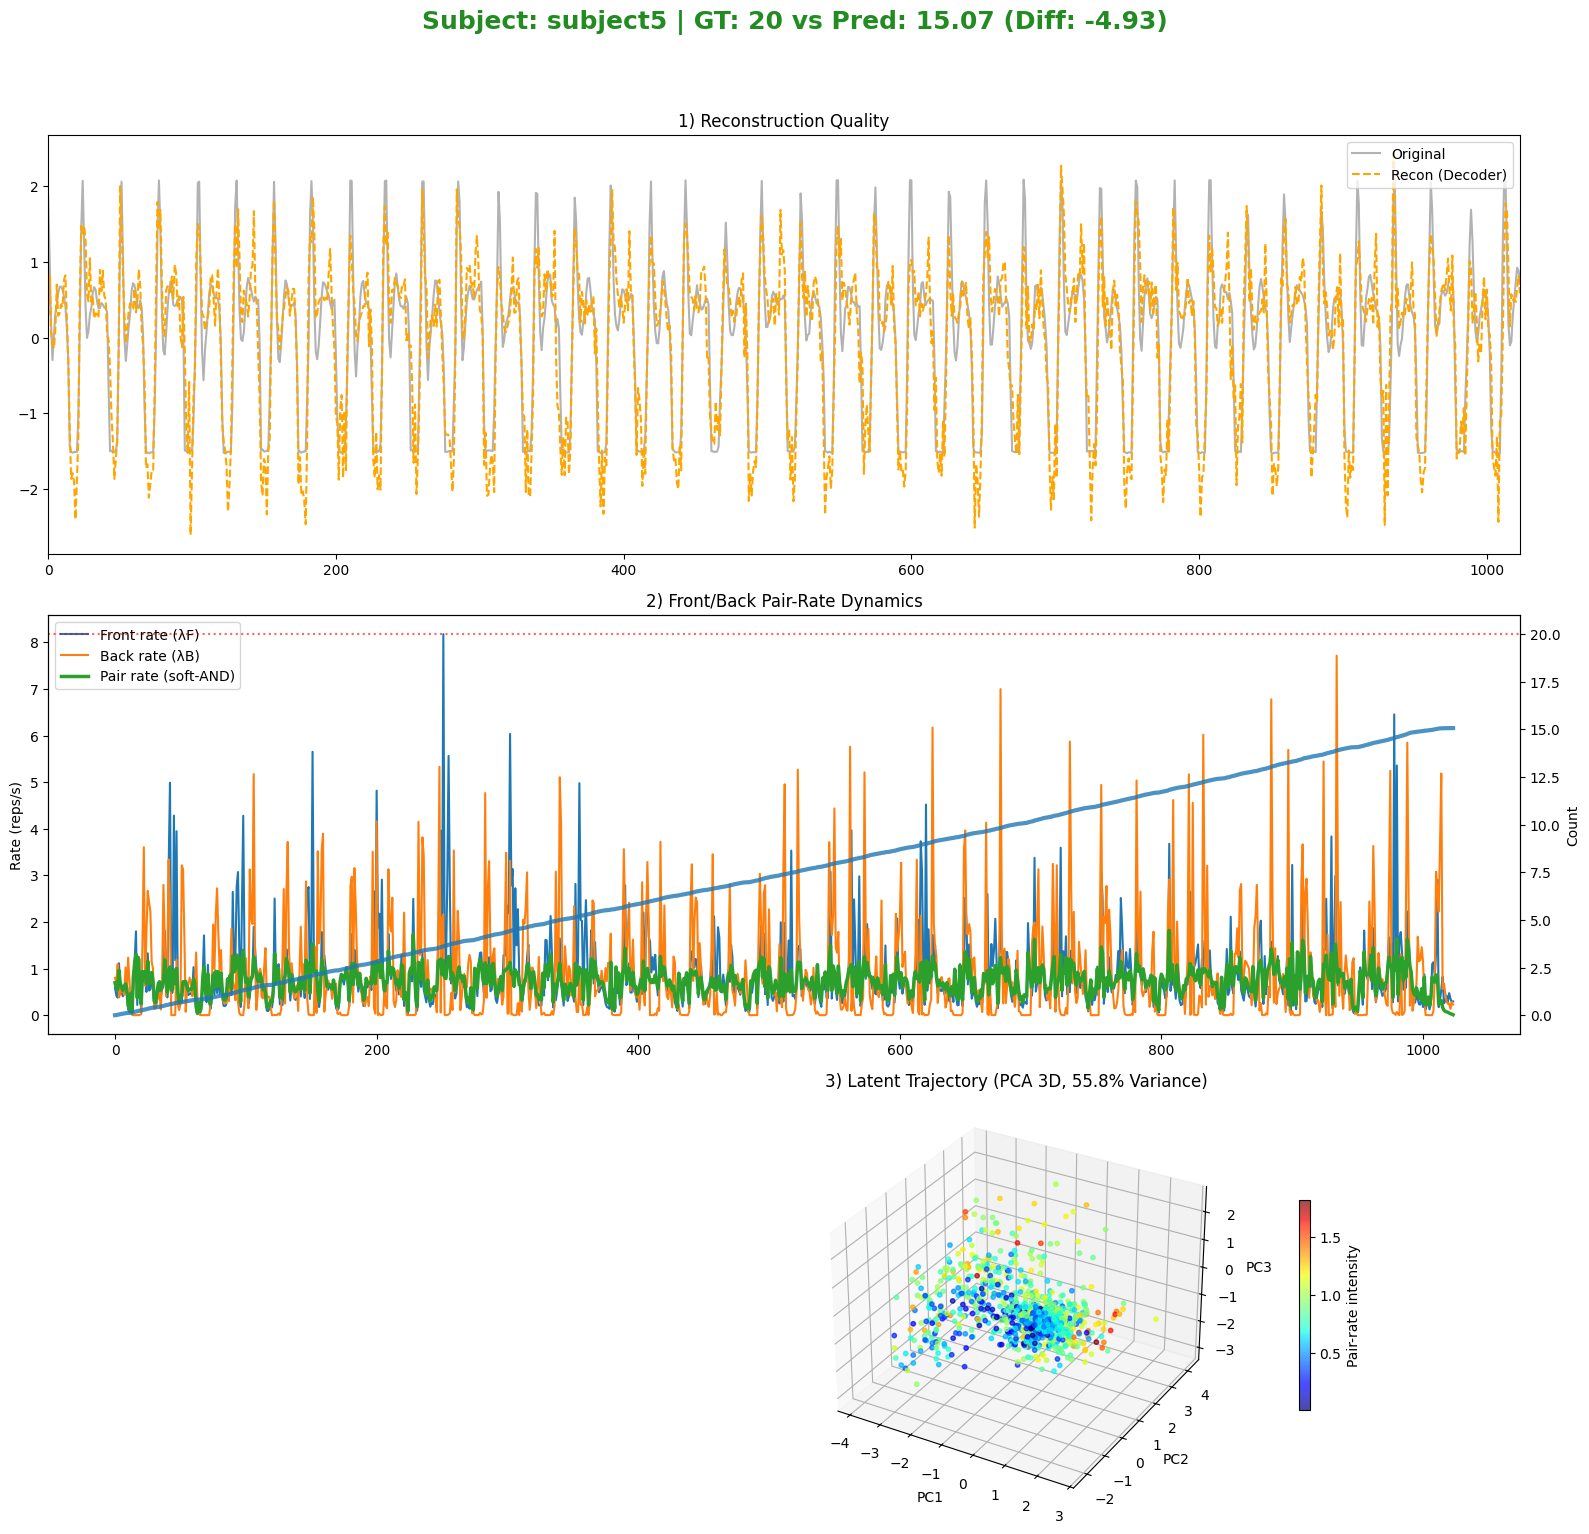

Done subject5...



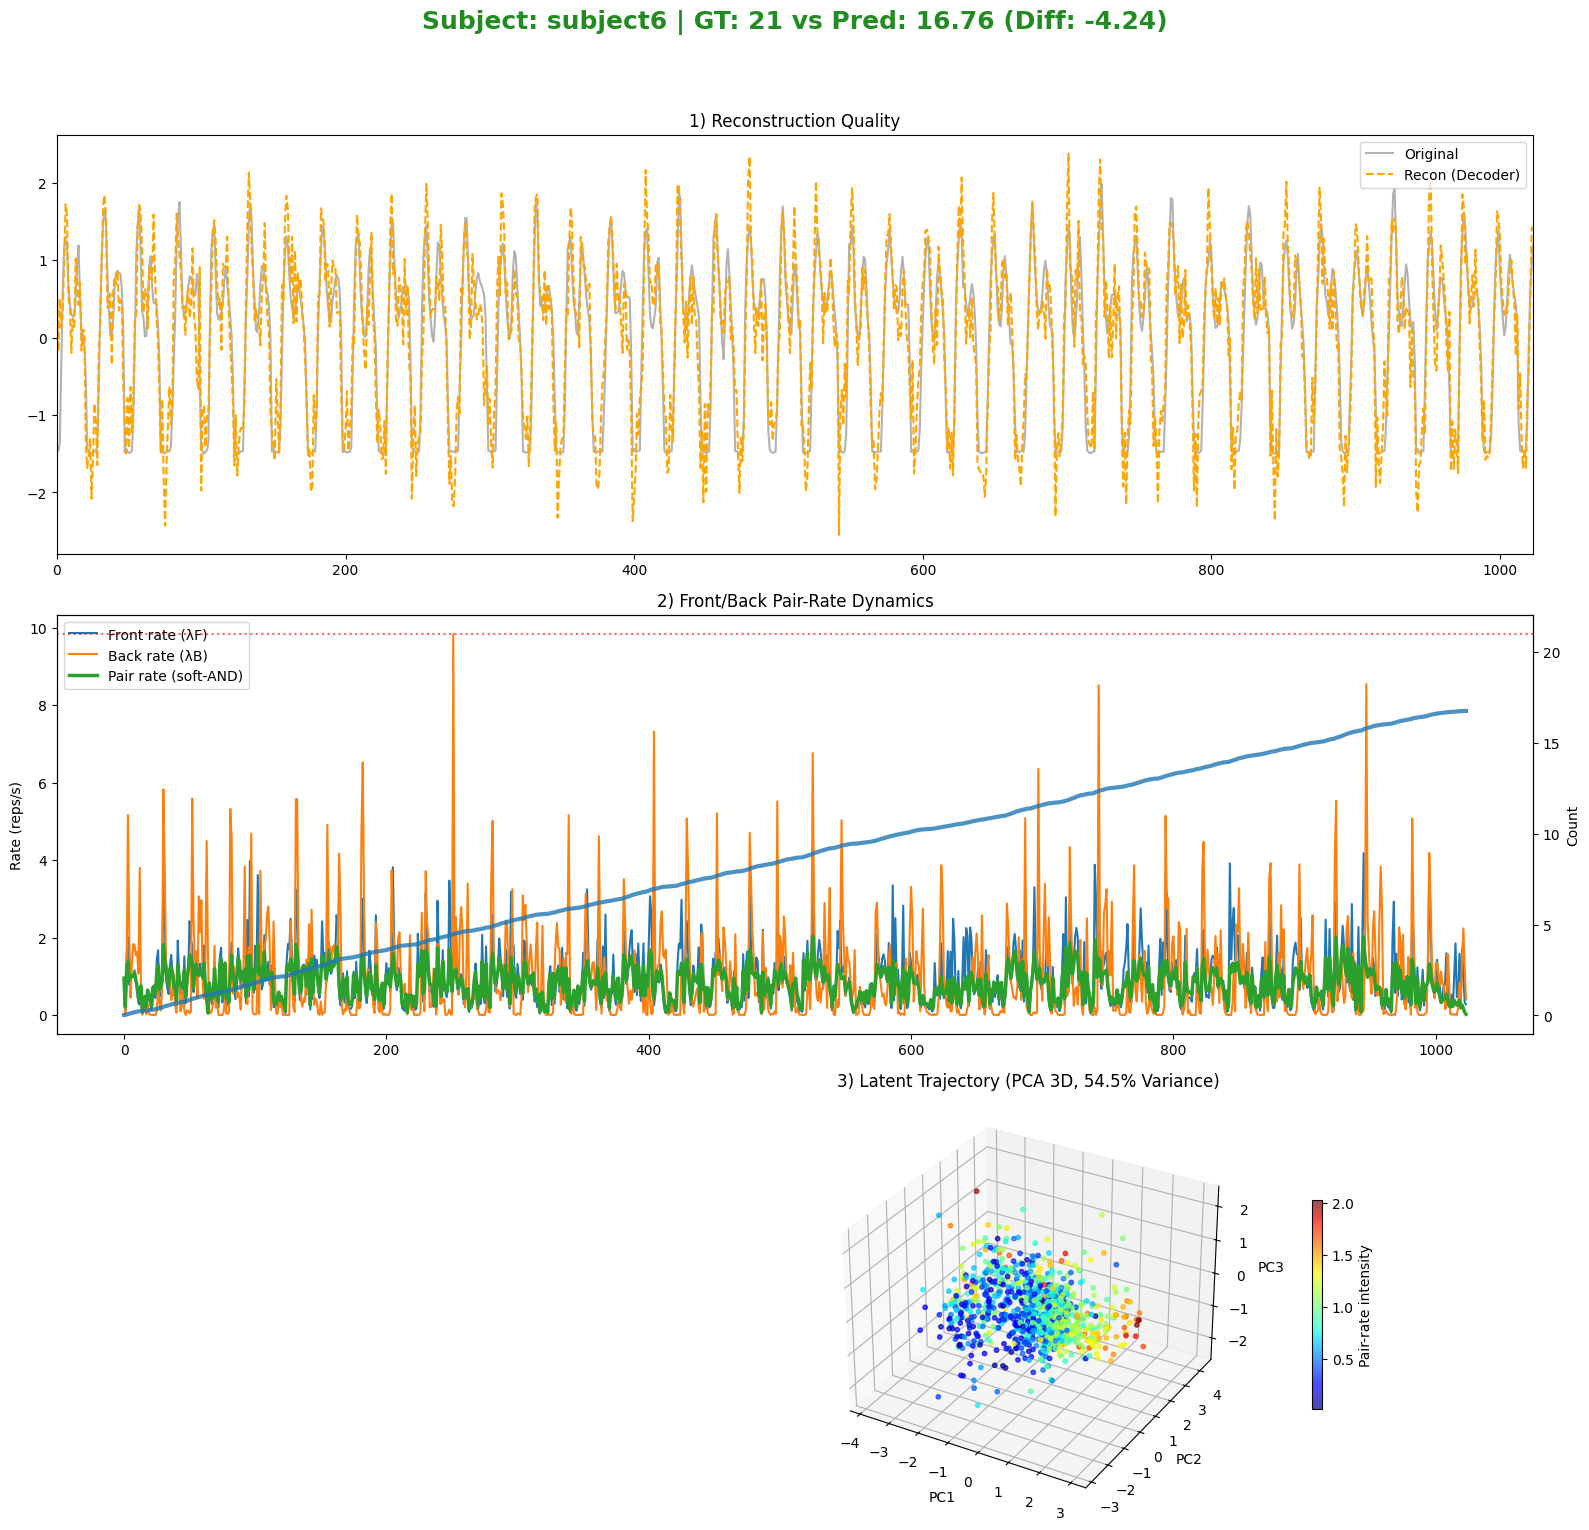

Done subject6...



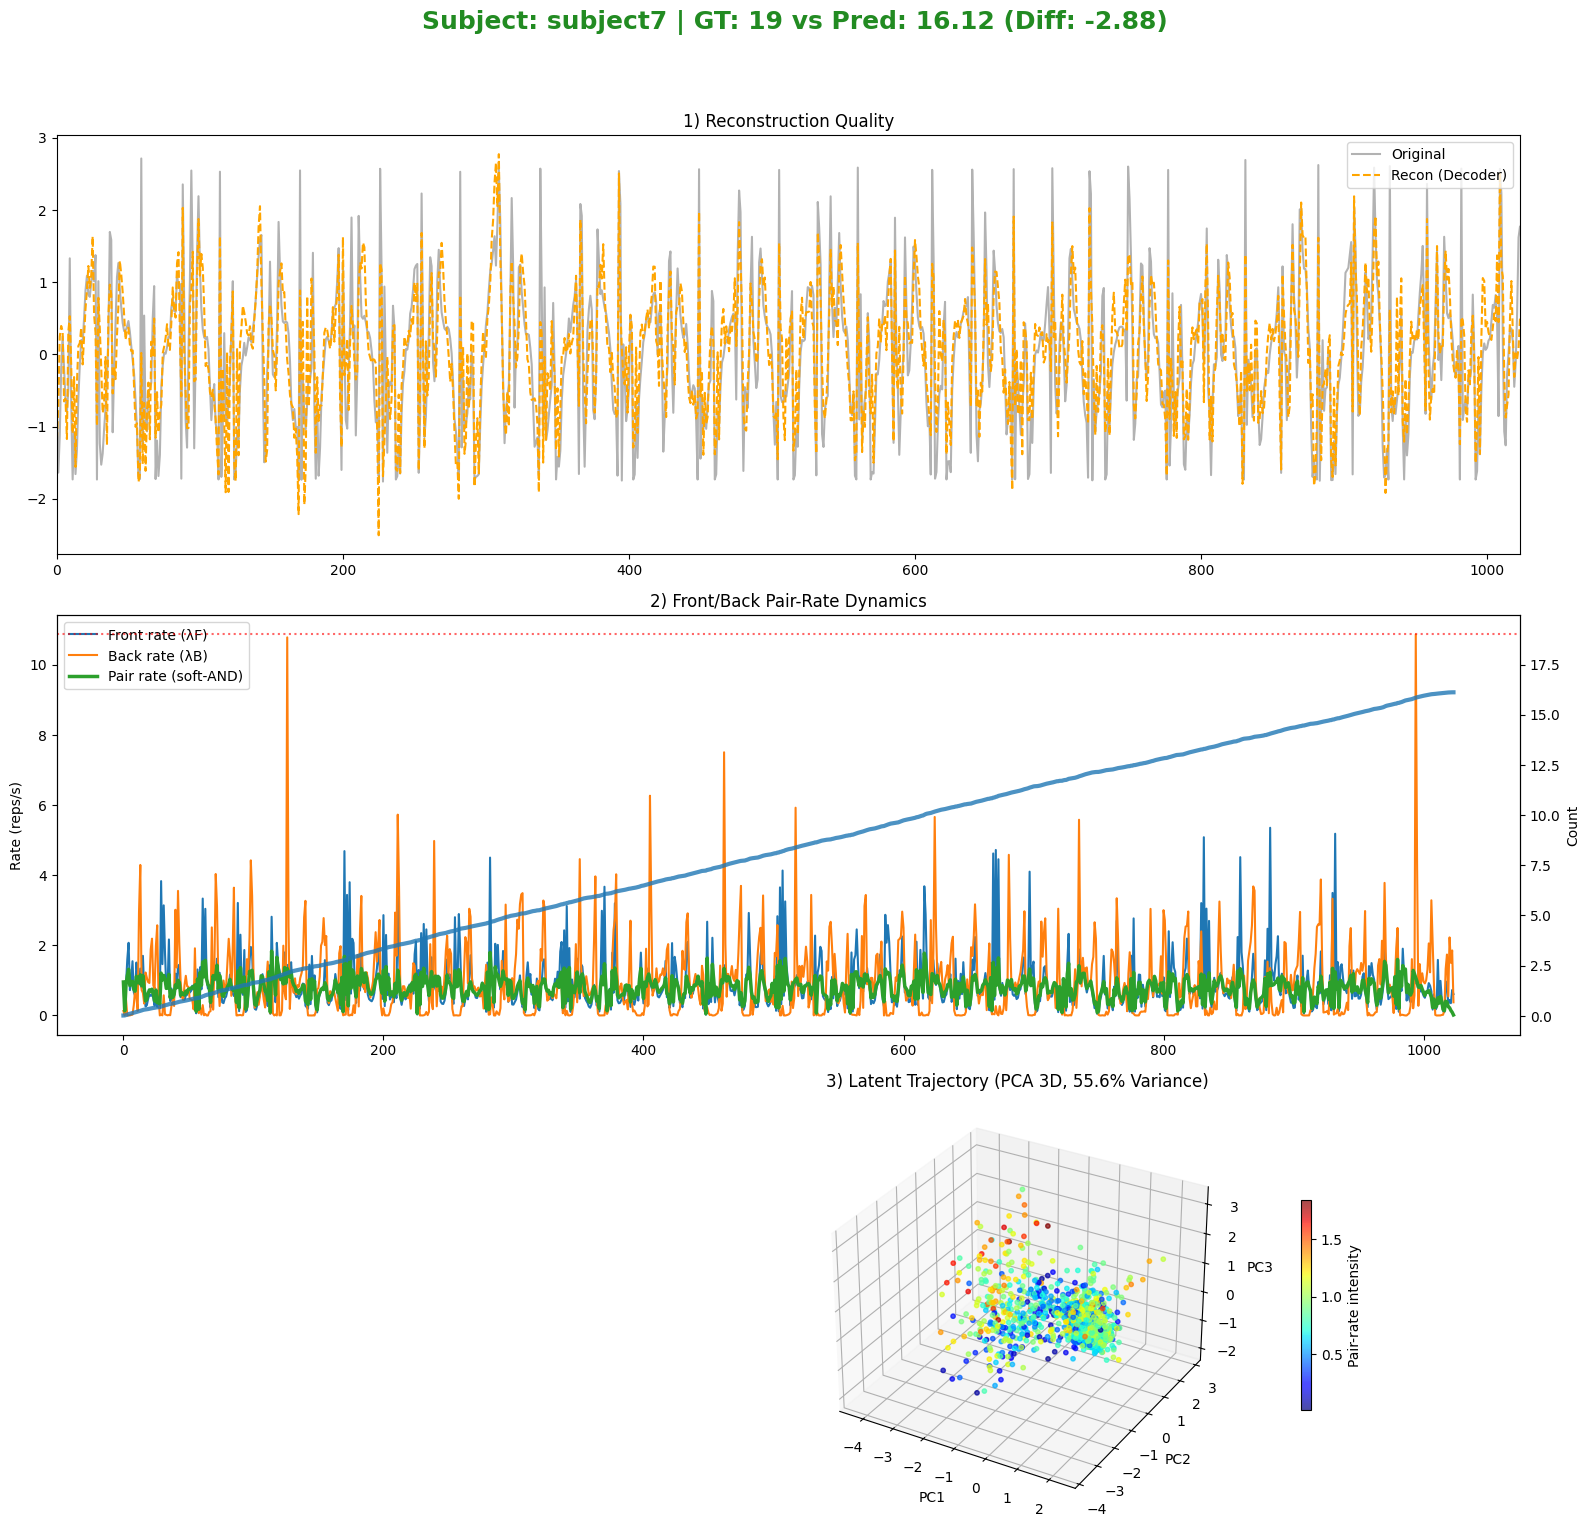

Done subject7...



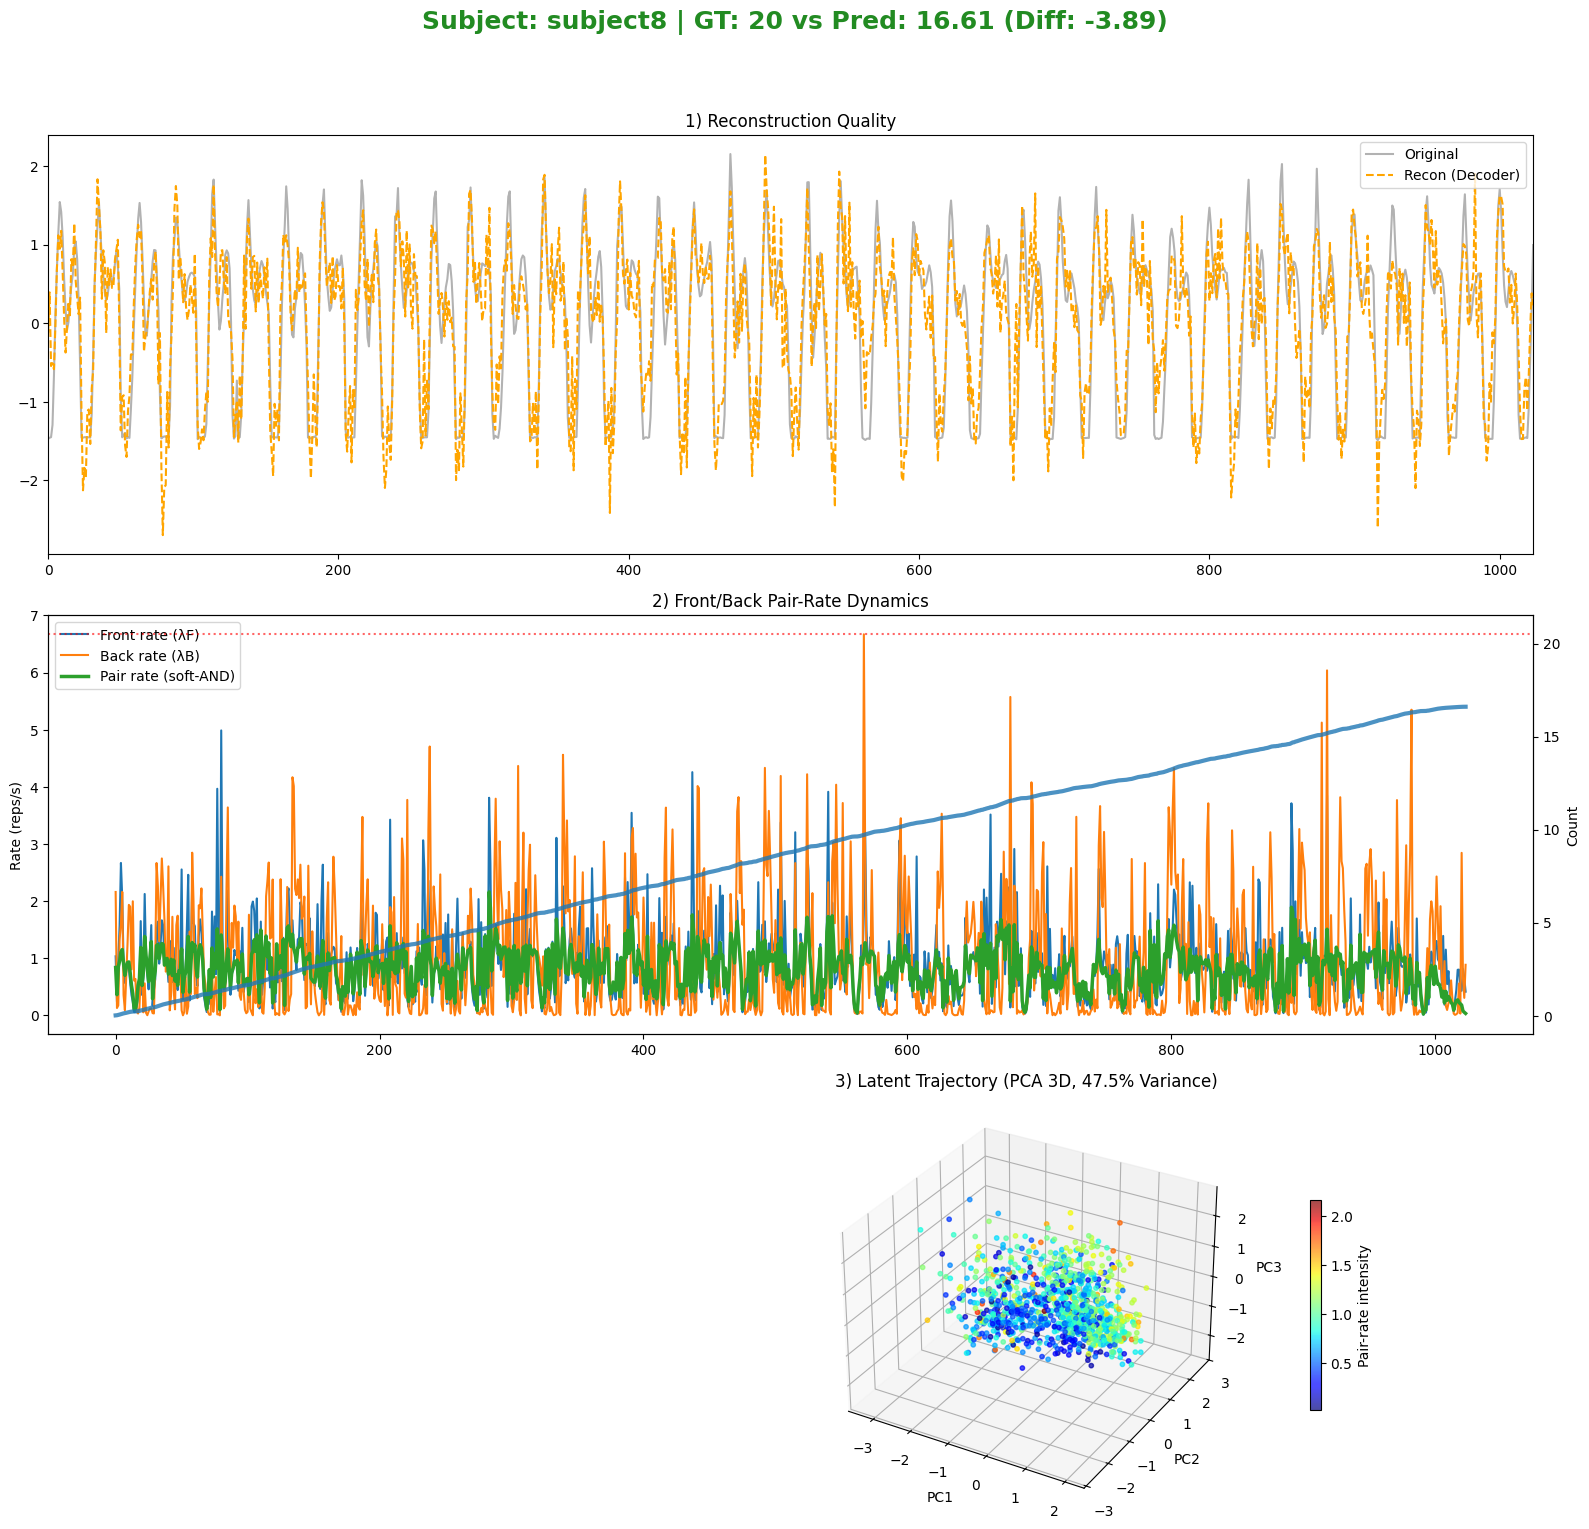

Done subject8...



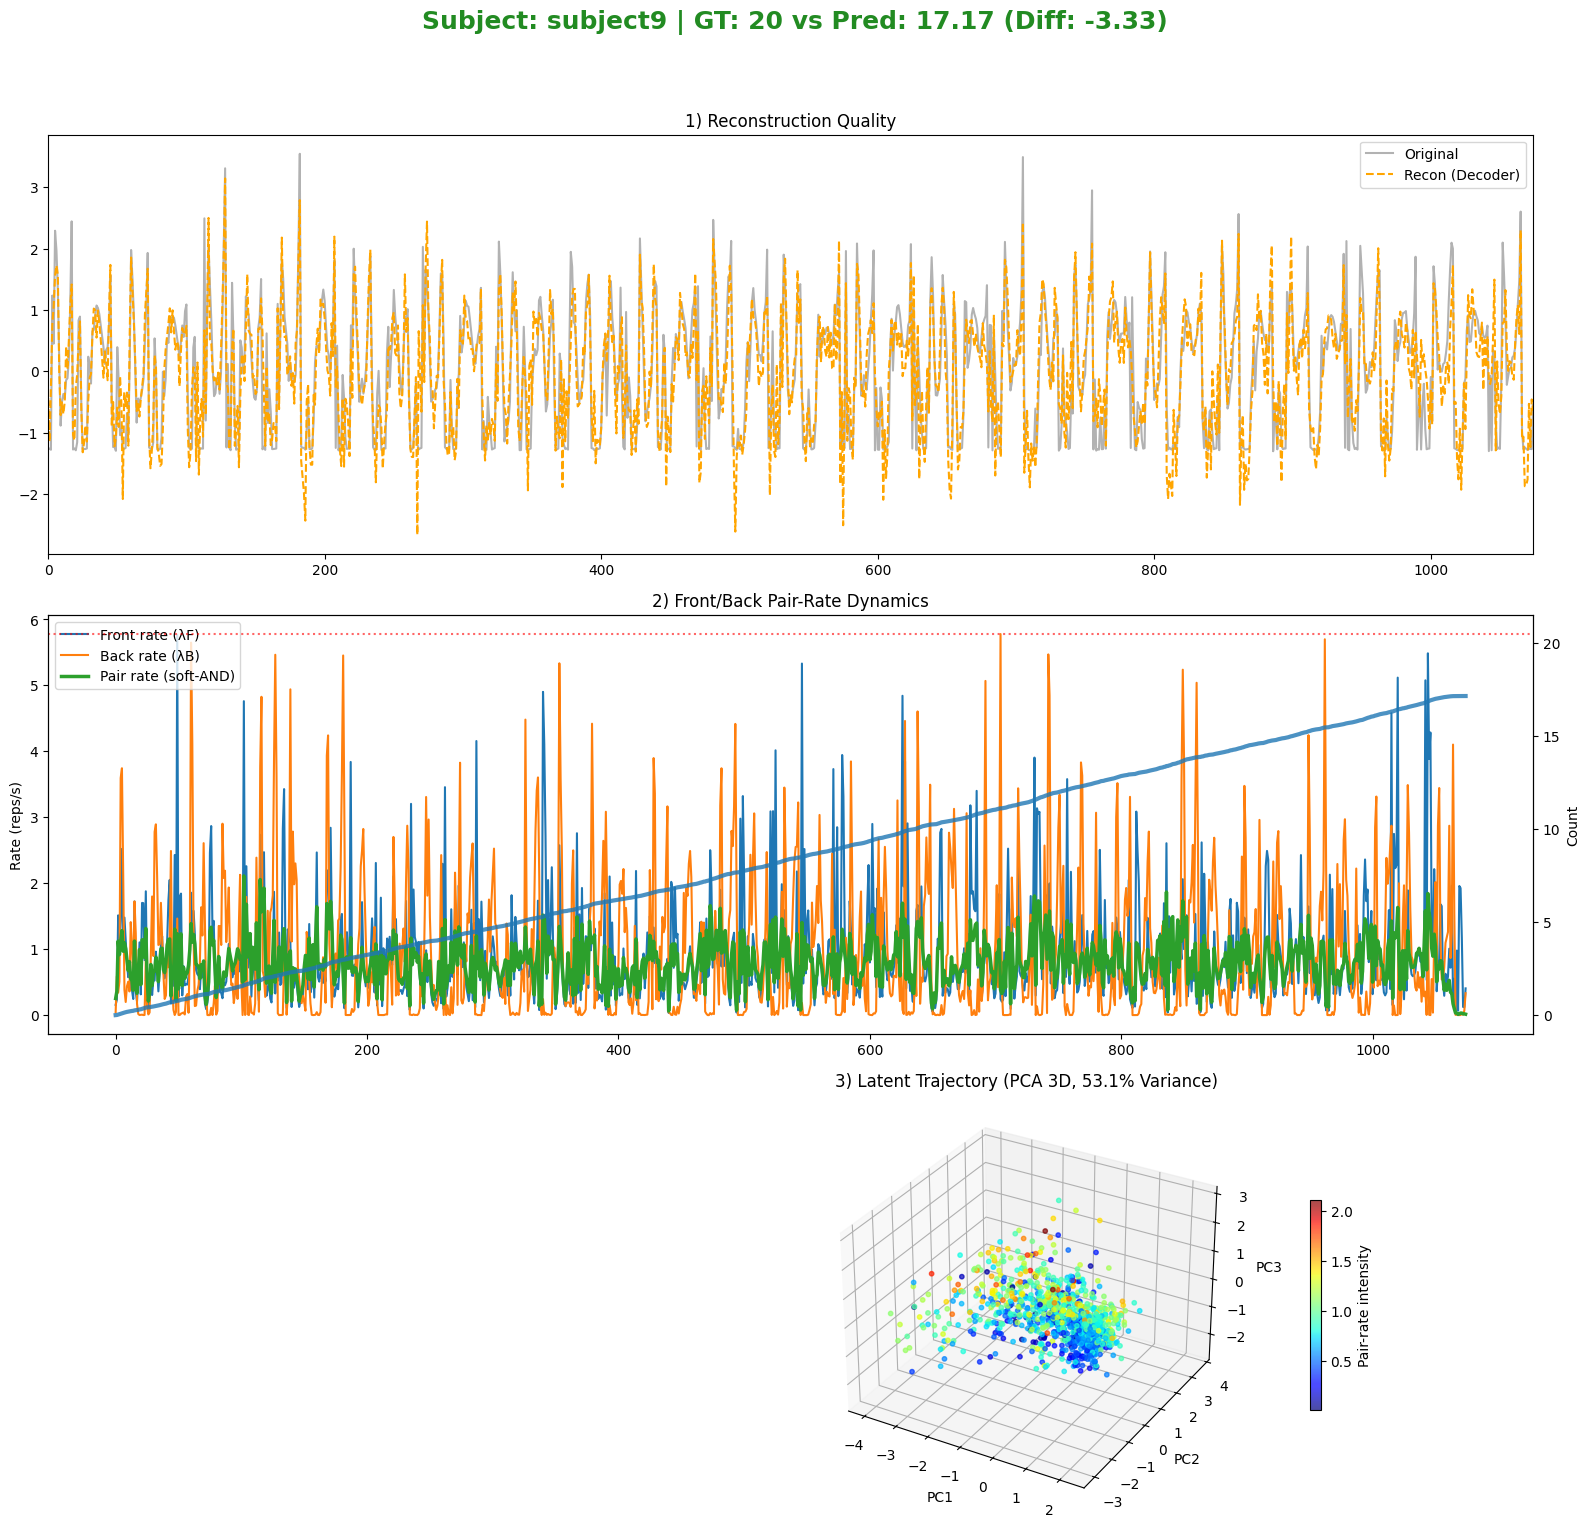

Done subject9...



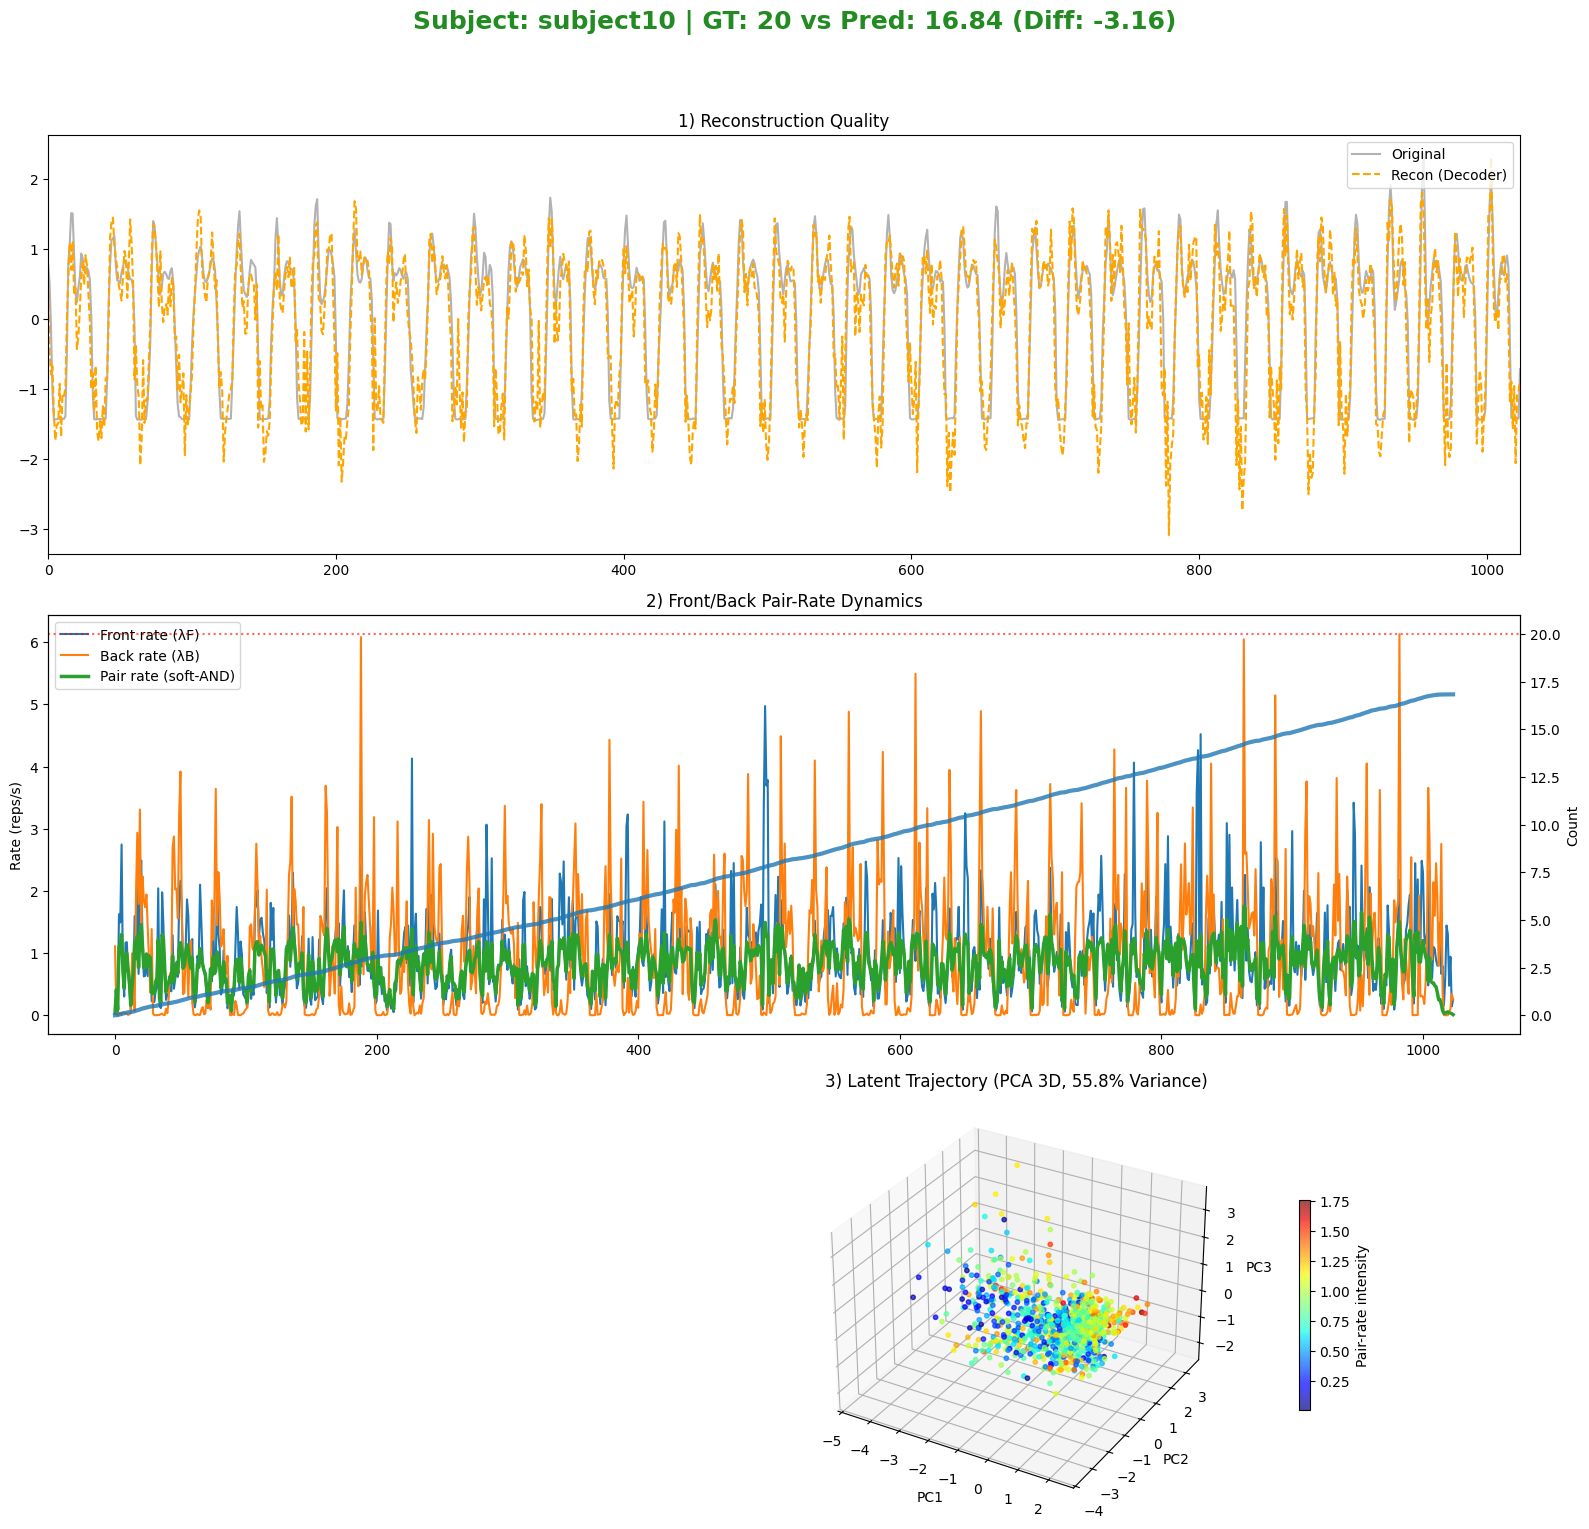

Done subject10...



In [1]:
# =========================
# ✅ Pair-aware (Front–Back) version
# - 핵심: front/back 두 개의 time-rate(λF_t, λB_t)를 예측하고,
#         "둘 다 있어야(rep 완성)" 카운트가 올라가도록 pair_rate를 구성합니다.
# - 감독은 여전히 count-only (약한 감독)이며,
#         (1) pair_rate가 GT rate를 맞추고
#         (2) front/back 누적량이 서로 비슷해지도록(balance loss)
#         (3) 시간적으로 매끈하도록(smoothness loss)
# =========================

import os
import glob
import random
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------------------------
# 1. Strict Seeding
# ------------------------------------------------------------------------------
def set_strict_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ------------------------------------------------------------------------------
# 2. Data Loading
# ------------------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,
                'count': float(gt_count),
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


# ------------------------------------------------------------------------------
# 3. Model Classes
# ------------------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        # x: (B, C, T)
        z = self.net(x)            # (B, D, T)
        z = z.transpose(1, 2)      # (B, T, D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        # z: (B, T, D)
        zt = z.transpose(1, 2)     # (B, D, T)
        x_hat = self.net(zt)       # (B, C, T)
        return x_hat


# ✅ 변경: Front/Back 두 스트림 출력 (2개)
class PairRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)   # [front_logit, back_logit]
        )

    def forward(self, z):
        # z: (B, T, D)
        out = self.net(z)          # (B, T, 2)
        return out


# ✅ 변경: pair_rate 구성 + balance/smoothness 옵션
class PairRateModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, lag_max=15,
                 lag_hidden=64, lag_tau=1.0):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = PairRateHead(latent_dim, hidden_dim)
        self.lag_max = lag_max
        self.lag_tau = lag_tau

        # 학습 가능한 샘플별 lag 예측 head
        self.lag_head = nn.Sequential(
            nn.Linear(latent_dim, lag_hidden),
            nn.ReLU(),
            nn.Linear(lag_hidden, lag_max + 1)  # (0..lag_max)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # 초기 rate를 너무 크게 만들지 않게 bias 음수
        nn.init.constant_(self.rate_head.net[-1].bias, -2.0)

    # --------------------------
    # (1) Shift helper
    # --------------------------
    @staticmethod
    def _shift(v, delta):
        B, T = v.shape
        out = v.new_zeros(B, T)
        if delta == 0:
            return v
        if delta > 0:
            out[:, :T - delta] = v[:, delta:]
        else:
            d = -delta
            out[:, d:] = v[:, :T - d]
        return out


    def _pool_z(self, z, mask=None, eps=1e-6):
        # z: (B,T,D), mask: (B,T)
        if mask is None:
            return z.mean(dim=1)  # (B,D)
        m = mask.to(dtype=z.dtype, device=z.device).unsqueeze(-1)  # (B,T,1)
        return (z * m).sum(dim=1) / (m.sum(dim=1) + eps)

    def _align_back_soft_instance(self, back_rate, z, mask=None):
        """
        back_rate: (B,T)
        z: (B,T,D) -> pooled -> lag_logits: (B,L+1) -> w: (B,L+1)
        aligned[t] = Σ_d w[d] * back[t+d]
        """
        z_pool = self._pool_z(z, mask)  # (B,D)
        lag_logits = self.lag_head(z_pool)  # (B,L+1)

        # ✅ temperature(optional). tau 낮추면 더 뾰족해짐(학습 후반에 anneal 가능)
        w = torch.softmax(lag_logits / self.lag_tau, dim=1)  # (B,L+1)

        aligned = torch.zeros_like(back_rate)
        for d in range(self.lag_max + 1):
            aligned += w[:, d].unsqueeze(1) * self._shift(back_rate, d)

        if mask is not None:
            aligned = aligned * mask.to(dtype=back_rate.dtype, device=back_rate.device)

        # 기대 lag(프레임)도 같이 반환
        idx = torch.arange(self.lag_max + 1, device=back_rate.device, dtype=back_rate.dtype)
        mean_lag = (w * idx.unsqueeze(0)).sum(dim=1)  # (B,)
        argmax_lag = torch.argmax(w, dim=1)           # (B,)
        return aligned, w, mean_lag, argmax_lag

    def forward(self, x, mask=None):
        z = self.encoder(x)              # (B,T,D)
        x_hat = self.decoder(z)          # (B,C,T)

        logits = self.rate_head(z)       # (B,T,2)
        front_rate = F.softplus(logits[..., 0])
        back_rate  = F.softplus(logits[..., 1])

        back_aligned, w, mean_lag, argmax_lag = self._align_back_soft_instance(back_rate, z, mask)

        pair_rate_t = 2.0 * (front_rate * back_aligned) / (front_rate + back_aligned + 1e-6)
        if mask is not None:
            pair_rate_t = pair_rate_t * mask

        # masked mean
        if mask is None:
            avg_pair_rate = pair_rate_t.mean(dim=1)
        else:
            avg_pair_rate = (pair_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "front_rate_t": front_rate,
            "back_rate_t": back_rate,
            "back_aligned_t": back_aligned,
            "pair_rate_t": pair_rate_t,
            "lag_w": w,
            "lag_mean": mean_lag,
            "lag_argmax": argmax_lag,
        }
        return avg_pair_rate, z, x_hat, aux


# ------------------------------------------------------------------------------
# 4. Dataset & Collate
# ------------------------------------------------------------------------------
class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []

    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),         # (B, C, T_max)
        "mask": torch.stack(masks),               # (B, T_max)
        "count": torch.stack(counts),             # (B,)
        "length": torch.tensor(lengths, dtype=torch.float32),  # (B,)
        "meta": metas
    }


# ------------------------------------------------------------------------------
# 5. Training
# ------------------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)              # (B,1,T)
    se = (x_hat - x) ** 2                    # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps  # valid(B*T)*C
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    """
    v: (B,T)  -> L1 smoothness on first difference
    """
    dv = torch.abs(v[:, 1:] - v[:, :-1])  # (B,T-1)
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    stats = {k: 0.0 for k in [
        'loss', 'loss_rate', 'loss_recon', 'loss_balance', 'loss_smooth',
        'mae_rate', 'mae_count'
    ]}

    fs = config["fs"]
    lam_recon   = config.get("lambda_recon", 1.0)
    lam_balance = config.get("lambda_balance", 0.2)   # ✅ front/back 누적 균형
    lam_overlap = config.get("lambda_overlap", 0.1)

    for batch in loader:
        x = batch["data"].to(device)         # (B,C,T)
        mask = batch["mask"].to(device)      # (B,T)
        y_count = batch["count"].to(device)  # (B,)
        length = batch["length"].to(device)  # (B,)

        duration = torch.clamp(length / fs, min=1e-6)
        y_rate = y_count / duration          # reps/s (pair 기준)

        optimizer.zero_grad()

        rate_hat, z, x_hat, aux = model(x, mask)

        # (1) pair rate 감독
        loss_rate = F.mse_loss(rate_hat, y_rate)

        # (2) recon (옵션이지만 representation 안정화)
        loss_recon = masked_recon_mse(x_hat, x, mask)

        # (3) balance: front/back 누적량이 비슷해야 1 rep가 완성됨
        #     누적 front_count ~= 누적 back_count
        front_t = aux["front_rate_t"]  # (B,T)
        back_t  = aux["back_rate_t"]   # (B,T)

        # count = ∑ rate * dt  (dt=1/fs)
        front_cnt = (front_t * mask).sum(dim=1) / fs
        back_cnt  = (back_t  * mask).sum(dim=1) / fs
        loss_balance = F.l1_loss(front_cnt, back_cnt)

        # (4) overlap penalty: same-time overlap 억제 (동시 peak 벌점)
        eps = 1e-6
        overlap0 = (front_t * back_t * mask).sum(dim=1) / (mask.sum(dim=1) + eps)  # (B,)
        loss_overlap0 = overlap0.mean()

        loss = (loss_rate
        + lam_recon * loss_recon
        + lam_balance * loss_balance
        + lam_overlap * loss_overlap0)

        loss.backward()
        optimizer.step()

        count_hat = rate_hat * duration

        stats['loss'] += loss.item()
        stats['loss_rate'] += loss_rate.item()
        stats['loss_recon'] += loss_recon.item()
        stats['loss_balance'] += loss_balance.item()
        stats['mae_rate'] += torch.abs(rate_hat - y_rate).mean().item()
        stats['mae_count'] += torch.abs(count_hat - y_count).mean().item()

    n = len(loader)
    return {k: v / n for k, v in stats.items()}


# ------------------------------------------------------------------------------
# 7. Main with CONFIG
# ------------------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            6: 'Waist bends forward',
            7: 'Frontal elevation of arms',
            8: 'Knees bending',
            12: 'Jump front & back'
        },
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z'],
            7: ['acc_arm_x', 'acc_arm_y', 'acc_arm_z', 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'],
            8: ['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z'],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,
        "lag_max": 30,  # 최대 15프레임 (약 0.3초, fs=50Hz 기준)
        "lag_tau": 1.0,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_balance": 0.1,   # ✅ front/back 쌍 구조 강제
        "lambda_overlap": 0.1,

        # Model Arch
        "hidden_dim": 128,
        "latent_dim": 16,

        "ALL_LABELS": [
            ("subject1", 12, 40/2),
            ("subject2", 12, 45/2),
            ("subject3", 12, 42/2),
            ("subject4", 12, 42/2),
            ("subject5", 12, 40/2),
            ("subject6", 12, 42/2),
            ("subject7", 12, 38/2),
            ("subject8", 12, 41/2),
            ("subject9", 12, 41/2),
            ("subject10", 12, 40/2),
        ],
    }

    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]
    loso_results = []

    print("\n" + "-"*50)
    print(" >>> Starting Leave-One-Subject-Out (LOSO) CV")
    print("-"*50)

    for fold_idx, test_subj in enumerate(subjects):
        set_strict_seed(CONFIG["seed"])

        train_labels = [x for x in CONFIG["ALL_LABELS"] if x[0] != test_subj]
        test_labels  = [x for x in CONFIG["ALL_LABELS"] if x[0] == test_subj]

        train_data = prepare_trial_list(train_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
        test_data = prepare_trial_list(test_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])

        if not test_data:
            print(f"[Skip] Fold {fold_idx+1}: {test_subj} has no data.")
            continue

        g = torch.Generator()
        g.manual_seed(CONFIG["seed"])
        train_loader = DataLoader(
            TrialDataset(train_data),
            batch_size=CONFIG["batch_size"],
            shuffle=True,
            collate_fn=collate_variable_length,
            generator=g,
            num_workers=0
        )

        input_ch = train_data[0]['data'].shape[1]
        model = PairRateModel(
            input_ch=input_ch,
            hidden_dim=CONFIG["hidden_dim"],
            latent_dim=CONFIG["latent_dim"],
            lag_max=CONFIG["lag_max"]
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

        for epoch in range(CONFIG["epochs"]):
            stats = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
            scheduler.step()

        model.eval()

        # fold 학습 직후 lag 분포 출력
        with torch.no_grad():
            b = next(iter(train_loader))
            x_dbg = b["data"].to(device)
            m_dbg = b["mask"].to(device)
            _, _, _, aux_dbg = model(x_dbg, m_dbg)

            w_mean = aux_dbg["lag_w"].mean(dim=0).cpu().numpy()   # 배치 평균 분포
            mean_lag = aux_dbg["lag_mean"].mean().item()
            argmax_lag = int(torch.mode(aux_dbg["lag_argmax"])[0].item())

            print(f"[Fold {fold_idx+1}] lag_w_mean = {np.round(w_mean,4)}")
            print(f"[Fold {fold_idx+1}] mean lag (frames) = {mean_lag:.2f} | mode(argmax lag) = {argmax_lag}")

        fold_mae = 0.0
        fold_res_str = ""

        for item in test_data:
            with torch.no_grad():
                x_tensor = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                duration = x_tensor.shape[2] / CONFIG["fs"]

                rate_hat, _, _, _ = model(x_tensor, mask=None)
                count_pred = rate_hat.item() * duration
                count_gt = float(item['count'])

                abs_err = abs(count_pred - count_gt)
                fold_mae += abs_err
                fold_res_str += f"[Pred: {count_pred:.1f} / GT: {count_gt:.0f}]"

        fold_mae /= len(test_data)
        loso_results.append(fold_mae)

        print(f"Fold {fold_idx+1:2d} | Test: {test_subj} | MAE: {fold_mae:.2f} | {fold_res_str}")

    print("="*50)
    print(f" >>> Final LOSO Result (Average MAE): {np.mean(loso_results):.3f}")
    print(f" >>> Standard Deviation: {np.std(loso_results):.3f}")
    print("="*50)

    # ------------------------------------------------------------------------------
    # 8. Visualization (pair-aware)
    # ------------------------------------------------------------------------------
    def visualize_all_subjects(model, full_data, config, device):
        print("="*60)
        print(" >>> Visualizing All 10 Subjects (Front/Back Pair Rates)")
        print("="*60)

        subject_list = [f"subject{i}" for i in range(1, 11)]

        gt_map = {item[0]: float(item[2]) for item in config["ALL_LABELS"]}

        for subj_id in subject_list:
            if subj_id not in full_data:
                print(f"[Skip] No data for {subj_id}")
                continue

            target_act_id = 12
            act_name = config["TARGET_ACTIVITIES_MAP"][target_act_id]
            feats = config["ACT_FEATURE_MAP"][target_act_id]

            if act_name not in full_data[subj_id]:
                continue

            raw_df = full_data[subj_id][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            model.eval()
            with torch.no_grad():
                x_tensor = torch.tensor(norm_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                rate_hat, z, x_hat, aux = model(x_tensor, mask=None)

                front = aux["front_rate_t"].squeeze(0).cpu().numpy()  # (T,)
                back  = aux["back_rate_t"].squeeze(0).cpu().numpy()   # (T,)
                pair  = aux["pair_rate_t"].squeeze(0).cpu().numpy()   # (T,)

                z_np = z.squeeze(0).cpu().numpy()                     # (T, D)
                x_hat_np = x_hat.squeeze(0).permute(1, 0).cpu().numpy()  # (T, C)

                # ✅ PCA 적용 후 그걸로 scatter
                pca = PCA(n_components=3)
                z_pca = pca.fit_transform(z_np)
                explained_var = np.sum(pca.explained_variance_ratio_) * 100.0

                duration = x_tensor.shape[2] / config["fs"]
                pred_count = float(rate_hat.item() * duration)
                gt_count = gt_map.get(subj_id, 0.0)
                diff = pred_count - gt_count
                error_color = 'red' if abs(diff) > 5.0 else 'forestgreen'

            fig = plt.figure(figsize=(16, 16))
            plt.suptitle(
                f"Subject: {subj_id} | GT: {gt_count:.0f} vs Pred: {pred_count:.2f} (Diff: {diff:+.2f})",
                fontsize=18, fontweight='bold', color=error_color
            )

            main_ch_idx = int(np.argmax(np.var(norm_np, axis=0)))

            # Row 1: Reconstruction
            ax1 = fig.add_subplot(3, 1, 1)
            ax1.plot(norm_np[:, main_ch_idx], 'k', alpha=0.3, label='Original')
            ax1.plot(x_hat_np[:, main_ch_idx], 'orange', linestyle='--', label='Recon (Decoder)')
            ax1.set_title("1) Reconstruction Quality")
            ax1.legend(loc='upper right')
            ax1.margins(x=0)

            # Row 2: Pair dynamics (front/back/pair + cumulative)
            ax2 = fig.add_subplot(3, 1, 2)
            t_axis = np.arange(len(pair))

            ax2.plot(t_axis, front, label='Front rate (λF)')
            ax2.plot(t_axis, back,  label='Back rate (λB)')
            ax2.plot(t_axis, pair,  linewidth=2.5, label='Pair rate (soft-AND)')

            ax2.set_ylabel('Rate (reps/s)')
            ax2.set_title("2) Front/Back Pair-Rate Dynamics")
            ax2.legend(loc='upper left')
            ax2.margins(x=0)

            ax2_r = ax2.twinx()
            cum_pair = np.cumsum(pair) / config["fs"]
            ax2_r.plot(t_axis, cum_pair, linewidth=3, label='Cumulative (pair)', alpha=0.8)
            ax2_r.axhline(y=gt_count, color='red', linestyle=':', alpha=0.6, label=f'GT: {gt_count:.0f}')
            ax2_r.set_ylabel('Count')

            # Row 3: Latent manifold (PCA)
            ax3 = fig.add_subplot(3, 1, 3, projection='3d')
            p = ax3.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=pair, cmap='jet', s=10, alpha=0.7)
            ax3.set_title(f"3) Latent Trajectory (PCA 3D, {explained_var:.1f}% Variance)")
            ax3.set_xlabel('PC1')
            ax3.set_ylabel('PC2')
            ax3.set_zlabel('PC3')
            fig.colorbar(p, ax=ax3, shrink=0.5, label='Pair-rate intensity')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

            print(f"Done {subj_id}...\n")

    visualize_all_subjects(model, full_data, CONFIG, device)


if __name__ == "__main__":
    main()